In [1]:
from google.colab import drive
drive.mount("/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [2]:
cd '/drive/My Drive/Audio_Speech_Data'

/drive/My Drive/Audio_Speech_Data


In [0]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
from numpy import argmax, mean, diff, log, nonzero
from scipy.signal import blackmanharris, correlate
from scipy.stats import norm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn
from  sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
random.seed(1)
import pickle

In [0]:
neutral_train = os.listdir("./Train/Neutral/")
neutral_train.sort()
emotional_train = os.listdir("./Train/Emotional/")
emotional_train.sort()
neutral_ref_train = os.listdir("./Train/Neutral_Ref/")
neutral_ref_train.sort()
test_emotional = os.listdir("./Test/Emotional/")
test_emotional.sort()
test_neutral = os.listdir("./Test/Neutral/")
test_neutral.sort()

Sample Plot of Neutral and Emotional

In [0]:
y, sr = librosa.load("./Train/Neutral/" + neutral_train[0])

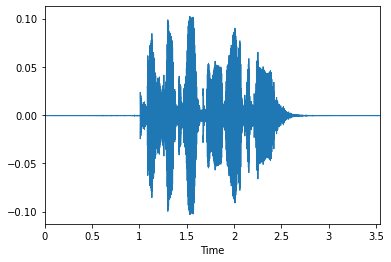

In [8]:
librosa.display.waveplot(y, sr=sr)

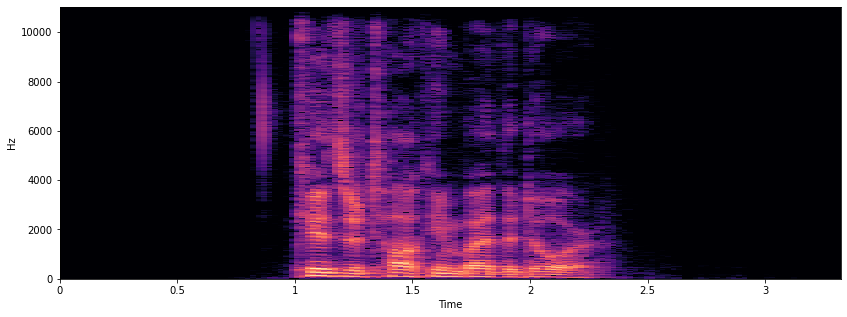

In [0]:
Y = librosa.stft(y)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')

In [0]:
y, sr = librosa.load("./Train/Emotional/" + emotional_train[0])

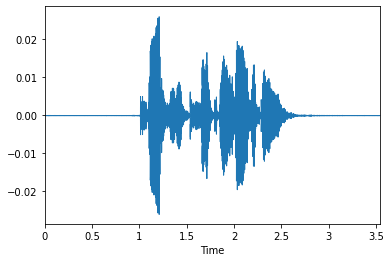

In [0]:
librosa.display.waveplot(y, sr=sr)

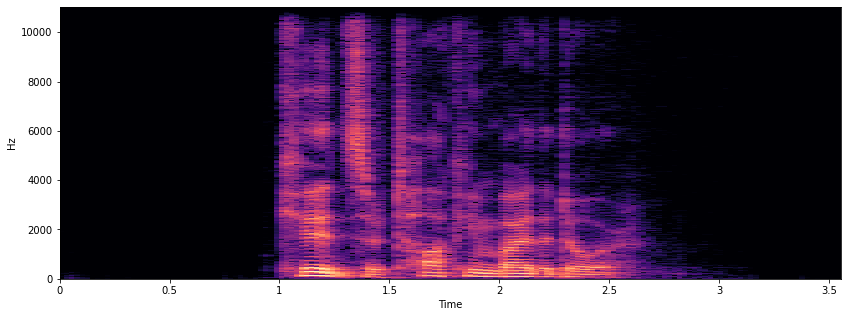

In [0]:
Y = librosa.stft(y)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')

Sample Audio of Neutral and Emotional

In [0]:
ipd.Audio("./Train/Emotional/" + emotional_train[0])

In [0]:
ipd.Audio("./Train/Neutral/" + neutral_train[0])

# **Feature Extraction**

In [0]:
def parabolic(f, x):
  try:
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)
  except:
    return 0

def freq_from_autocorr(sig, fs):
    """
    Estimate frequency using autocorrelation
    """    
    corr = correlate(sig, sig, mode='full')
    corr = corr[len(corr)//2:]
    d = diff(corr)
    
    try:
      start = nonzero(d > 0)[0][0]
    except:
      return -1
    peak = argmax(corr[start:]) + start
    ret = parabolic(corr, peak)
    if ret == 0:
      return -1
    px, py = ret
    return fs / px

In [0]:
def find_F0_contour(y, sr):
  numsamples = len(y)
  samppersec = sr
  sampper40 = int(sr/25)
  sampper30 = sr*3/100
  sampper10 = int(sr/100)
  i = 0
  F0_contour = []
  while(i + sampper40 < numsamples):
    sig = y[i : i + sampper40]
    val = freq_from_autocorr(sig, sr)
    i = i + sampper10
    if val != -1:
      F0_contour.append(val)
  # print(len(F0_contour))
  return F0_contour

In [0]:
def get_features(F0c):
  mean = np.mean(F0c)
  std = np.std(F0c)
  median = np.median(F0c)
  rangee = max(F0c) - min(F0c)
  Q1 = np.percentile(F0c, 25, interpolation = 'midpoint') 
  Q3 = np.percentile(F0c, 75, interpolation = 'midpoint') 
  IQR = Q3 - Q1
  return [mean, std, median, rangee, Q1, Q3, IQR]

In [0]:
features_neutral_ref = []
features_neutral = []
features_emotional = []
features_test_emotional = []
features_test_neutral = []

d_speaker_to_F0contour_neutral_ref = {}
d_F0contour_to_speaker_neutral_ref = {}
d_speaker_to_feature_neutral_ref = {}
d_feature_to_speaker_neutral_ref = {}

d_speaker_to_F0contour_neutral = {}
d_F0contour_to_speaker_neutral = {}
d_speaker_to_feature_neutral = {}
d_feature_to_speaker_neutral = {}

d_speaker_to_F0contour_emotional = {}
d_F0contour_to_speaker_emotional = {}
d_speaker_to_feature_emotional = {}
d_feature_to_speaker_emotional = {}

d_speaker_to_F0contour_test_emotional = {}
d_F0contour_to_speaker_test_emotional = {}
d_speaker_to_feature_test_emotional = {}
d_feature_to_speaker_test_emotional = {}

d_speaker_to_F0contour_test_neutral = {}
d_F0contour_to_speaker_test_neutral = {}
d_speaker_to_feature_test_neutral = {}
d_feature_to_speaker_test_neutral = {}

In [0]:
def find_all_features(arr, path, d1, d2, d3, d4, store):
  for n in range(len(arr)):
    # print(n, arr[n])
    y, sr = librosa.load(path + arr[n])
    # print(y.shape)
    
    F0_contour = find_F0_contour(y, sr)
    
    array = arr[n][:-4].split("-")
    speaker = int(array[-1])
    if speaker not in d1:
      d1[speaker] = [F0_contour]
      
    else:
      d1[speaker].append(F0_contour)
      
    F0_contour = np.array(F0_contour)
    d2[F0_contour.tostring()] = speaker

    feature = get_features(F0_contour)
    if speaker not in d3:
      d3[speaker] = [feature]
    else:
      d3[speaker].append(feature)
    
    feature = np.array(feature)
    d4[feature.tostring()] = speaker
    
    store.append(feature)
  return d1, d2, d3, d4, store

In [0]:
# d_speaker_to_F0contour_neutral_ref, d_F0contour_to_speaker_neutral_ref, d_speaker_to_feature_neutral_ref, d_feature_to_speaker_neutral_ref, features_neutral_ref = find_all_features(neutral_ref_train, "./Train/Neutral_Ref/", d_speaker_to_F0contour_neutral_ref, d_F0contour_to_speaker_neutral_ref, d_speaker_to_feature_neutral_ref, d_feature_to_speaker_neutral_ref, features_neutral_ref)

In [0]:
# numerator = np.mean(features_neutral_ref, axis=0)[0]

In [0]:
# d_speaker_to_F0contour_neutral, d_F0contour_to_speaker_neutral, d_speaker_to_feature_neutral, d_feature_to_speaker_neutral, features_neutral = find_all_features(neutral_train, "./Train/Neutral/", d_speaker_to_F0contour_neutral, d_F0contour_to_speaker_neutral, d_speaker_to_feature_neutral, d_feature_to_speaker_neutral, features_neutral)

In [0]:
# d_speaker_to_F0contour_emotional, d_F0contour_to_speaker_emotional, d_speaker_to_feature_emotional, d_feature_to_speaker_emotional, features_emotional = find_all_features(emotional_train, "./Train/Emotional/", d_speaker_to_F0contour_emotional, d_F0contour_to_speaker_emotional, d_speaker_to_feature_emotional, d_feature_to_speaker_emotional, features_emotional)

In [0]:
d_speaker_to_F0contour_test_emotional, d_F0contour_to_speaker_test_emotional, d_speaker_to_feature_test_emotional, d_feature_to_speaker_test_emotional, features_test_emotional = find_all_features(test_emotional, "./Test/Emotional/", d_speaker_to_F0contour_test_emotional, d_F0contour_to_speaker_test_emotional, d_speaker_to_feature_test_emotional, d_feature_to_speaker_test_emotional, features_test_emotional)

In [0]:
d_speaker_to_F0contour_test_neutral, d_F0contour_to_speaker_test_neutral, d_speaker_to_feature_test_neutral, d_feature_to_speaker_test_neutral, features_test_neutral = find_all_features(test_neutral, "./Test/Neutral/", d_speaker_to_F0contour_test_neutral, d_F0contour_to_speaker_test_neutral, d_speaker_to_feature_test_neutral, d_feature_to_speaker_test_neutral, features_test_neutral)

In [0]:
# pickle.dump(features_test_neutral, open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_test_neutral.pk", 'wb'))
# pickle.dump(features_test_emotional, open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_test_emotional.pk", 'wb'))

In [0]:
# pickle.dump(d_speaker_to_feature_test, open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_test.pk", 'wb'))
# pickle.dump(d_feature_to_speaker_test, open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_test.pk", 'wb'))

In [0]:
# pickle.dump(features_test, open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_test.pk", 'wb'))

In [0]:
# pickle.dump(d_speaker_to_feature_neutral_ref, open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_neutral_ref.pk", 'wb'))
# pickle.dump(d_speaker_to_feature_neutral, open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_neutral.pk", 'wb'))
# pickle.dump(d_speaker_to_feature_emotional, open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_emotional.pk", 'wb'))

In [0]:
# pickle.dump(features_neutral_ref, open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_neutral_ref.pk", 'wb'))
# pickle.dump(features_neutral, open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_neutral.pk", 'wb'))
# pickle.dump(features_emotional, open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_emotional.pk", 'wb'))

In [115]:
d_feature_to_speaker_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_neutral_ref.pk", 'rb'))
d_feature_to_speaker_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_neutral.pk", 'rb'))
d_feature_to_speaker_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_emotional.pk", 'rb'))
d_feature_to_speaker_test = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_test.pk", 'rb'))

d_speaker_to_feature_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_neutral_ref.pk", 'rb'))
d_speaker_to_feature_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_neutral.pk", 'rb'))
d_speaker_to_feature_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_emotional.pk", 'rb'))
d_speaker_to_feature_test = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_test.pk", 'rb'))

features_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_neutral_ref.pk", 'rb'))
features_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_neutral.pk", 'rb'))
features_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_emotional.pk", 'rb'))
features_test_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_test_emotional.pk", 'rb'))
features_test_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_test_neutral.pk", 'rb'))


numerator = np.mean(features_neutral_ref, axis=0)[0]
print(numerator)

features_neutral_ref = np.array(features_neutral_ref)
features_neutral = np.array(features_neutral)
features_emotional = np.array(features_emotional)
features_test_emotional = np.array(features_test_emotional)
features_test_neutral = np.array(features_test_neutral)


print(features_neutral_ref.shape)
print(features_neutral.shape)
print(len(d_feature_to_speaker_neutral))
print(features_emotional.shape)
print(features_test_emotional.shape)
print(features_test_neutral.shape)
print(len(d_feature_to_speaker_emotional))

2481.114366442635
(24, 7)
(54, 7)
54
(1008, 7)
(336, 7)
(24, 7)
1007


In [0]:
# d_feature_to_speaker_emotional = {}
# d_speaker_to_d_feature_emotional = {}

# for elem in d_F0contour_to_speaker_emotional:
#   speaker = d_F0contour_to_speaker_emotional[elem]
#   feature = get_features(np.fromstring(elem))
#   d_feature_to_speaker_emotional[np.array(feature).tostring()] = speaker
#   if speaker not in d_speaker_to_d_feature_emotional:
#     d_speaker_to_d_feature_emotional[speaker] = [feature]
#   else:
#     d_speaker_to_d_feature_emotional[speaker].append(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [0]:
def train_gmm(features):
  means = features[:,0]
  stds = features[:,1]
  medians = features[:,2]
  ranges = features[:,3]
  Q1s = features[:,4]
  Q3s = features[:,5]
  IQRs = features[:,6]

  gmm1 = GaussianMixture(2)
  gmm1.fit(means.reshape(-1,1))
  t1 = gmm1.means_, gmm1.covariances_

  gmm2 = GaussianMixture(2)
  gmm2.fit(stds.reshape(-1,1))
  t2 = gmm2.means_, gmm2.covariances_

  gmm3 = GaussianMixture(2)
  gmm3.fit(medians.reshape(-1,1))
  t3 = gmm3.means_, gmm3.covariances_

  gmm4 = GaussianMixture(2)
  gmm4.fit(ranges.reshape(-1,1))
  t4 = gmm4.means_, gmm4.covariances_

  gmm5 = GaussianMixture(2)
  gmm5.fit(Q1s.reshape(-1,1))
  t5 = gmm5.means_, gmm5.covariances_

  gmm6 = GaussianMixture(2)
  gmm6.fit(Q3s.reshape(-1,1))
  t6 = gmm6.means_, gmm6.covariances_

  gmm7 = GaussianMixture(2)
  gmm7.fit(IQRs.reshape(-1,1))
  t7 = gmm7.means_, gmm7.covariances_

  # t1 = (np.mean(means), np.std(means))
  # t2 = (np.mean(stds), np.std(stds))
  # t3 = (np.mean(medians), np.std(medians))
  # t4 = (np.mean(ranges), np.std(ranges))
  # t5 = (np.mean(Q1s), np.std(Q1s))
  # t6 = (np.mean(Q3s), np.std(Q3s))
  # t7 = (np.mean(IQRs), np.std(IQRs))

  return [t1, t2, t3, t4, t5, t6, t7]

In [0]:
def find_likelihood(dpt, gmms):
  vec = []
  for g in range(len(gmms)):
    gmm = gmms[g]
    means = np.squeeze(gmm[0])
    varis = np.squeeze(gmm[1])
    loc1 = means[0]
    scale1 = np.sqrt(varis[0])
    v1 = norm.pdf(dpt[g], loc1, scale1)

    loc2 = means[1]
    scale2 = np.sqrt(varis[1])
    v2 = norm.pdf(dpt[g], loc2, scale2)
    
    vec.append(v1 + v2)
  return vec

In [0]:
def check_percent_changes(a, b):
  assert len(a) == len(b)
  n = np.sum(a != b)
  assert n == len(a) - np.sum(a == b)
  return n * 100 / len(a)

In [0]:
def find_scaling_factors(x, y, p):
  neutral_indices = np.where(p == 0)
  # neutral_indices = np.array(list(map(int, neutral_indices[0])))
  # print(neutral_indices, len(neutral_indices))
  if len(neutral_indices) == 0:
    factors = {}
    for l in range(num_speakers):
      factors[l] = 1
    return factors

  classified_neutral = x[neutral_indices]
  
  factors = {}
  counts = {}

  for l in range(num_speakers):
    factors[l] = 0
    counts[l] = 0

  for feature in classified_neutral:
    # print(feature)
    try:
      speaker = d_feature_to_speaker_emotional[feature.tostring()]
      factors[speaker - 1] += feature[0]
      counts[speaker - 1] += 1
    except:
        speaker = d_feature_to_speaker_neutral[feature.tostring()]
        factors[speaker - 1] += feature[0]
        counts[speaker - 1] += 1
  
  for l in range(num_speakers):
    if counts[l] == 0: #What is the factor if not observed
      factors[l] = 1
    else:
      denominator = factors[l]/counts[l]
      factors[l] = numerator/denominator
    
    assert factors[l] != 0
    assert factors[l] != np.inf
  
  return factors

In [0]:
# def create_train_val_xy(fitness_measures_emotional, fitness_measures_neutral):
#     train_feature_matrix = np.zeros((72, 7))
#     val_feature_matrix = np.zeros((36, 7))
#     train_labels = np.zeros(72)
#     val_labels = np.zeros(36)

#     train_feat_ind = 0
#     val_feat_ind = 0

#     for i in range(1, 19):
#         train_feature_matrix[train_feat_ind] = fitness_measures_neutral[i][0]
#         train_labels[train_feat_ind] = 0
#         train_feat_ind += 1
#         train_feature_matrix[train_feat_ind] = fitness_measures_neutral[i][1]
#         train_labels[train_feat_ind] = 0
#         train_feat_ind += 1
#         val_feature_matrix[val_feat_ind] = fitness_measures_neutral[i][2]
#         val_labels[val_feat_ind] = 0
#         val_feat_ind += 1

#     for i in range(1, 19):
#         train_feature_matrix[train_feat_ind] = fitness_measures_emotional[i][0]
#         train_labels[train_feat_ind] = 1
#         train_feat_ind+=1
#         train_feature_matrix[train_feat_ind] = fitness_measures_emotional[i][1]
#         train_labels[train_feat_ind] = 1
#         train_feat_ind+=1
#         val_feature_matrix[val_feat_ind] = fitness_measures_emotional[i][2]
#         val_labels[val_feat_ind] = 1
#         val_feat_ind+=1

#     return train_feature_matrix, val_feature_matrix, train_labels, val_labels

# **Iterative** **Feature** **Normalization**

In [0]:
num_bootstraps = 400
num_neutral = 54
num_emotional = 1008
num_features = 7
num_speakers = 18

Streaming output truncated to the last 5000 lines.
VAL ACC = 0.7575757575757576
PERCENT CHANGE = 10.185185185185185
-------------- IFN Iteration 4 -------------
TRAIN ACC = 0.68
VAL ACC = 0.7878787878787878
PERCENT CHANGE = 8.333333333333334
-------------- IFN Iteration 5 -------------
TRAIN ACC = 0.7466666666666667
VAL ACC = 0.7272727272727273
PERCENT CHANGE = 17.59259259259259
TEST ACC = 0.4111111111111111
Bootstrap: 201
-------------- IFN Iteration 0 -------------
TRAIN ACC = 0.64
VAL ACC = 0.7272727272727273
PERCENT CHANGE = 100.0
-------------- IFN Iteration 1 -------------
TRAIN ACC = 0.6133333333333333
VAL ACC = 0.6363636363636364
PERCENT CHANGE = 23.14814814814815
-------------- IFN Iteration 2 -------------
TRAIN ACC = 0.6533333333333333
VAL ACC = 0.6363636363636364
PERCENT CHANGE = 12.037037037037036
-------------- IFN Iteration 3 -------------
TRAIN ACC = 0.6533333333333333
VAL ACC = 0.7575757575757576
PERCENT CHANGE = 14.814814814814815
-------------- IFN Iteration 4 ------

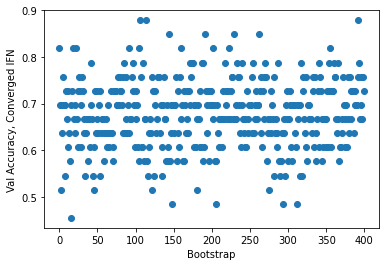

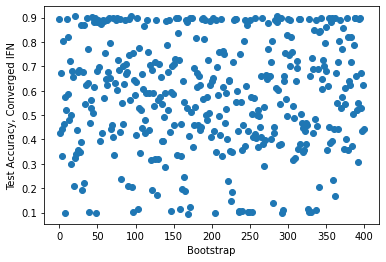

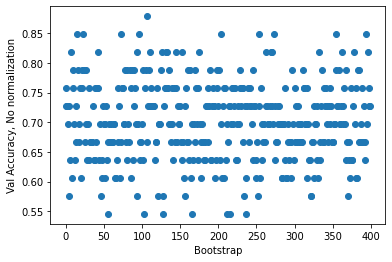

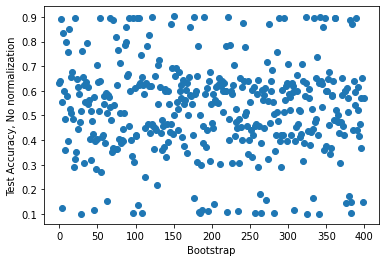

In [157]:
avgaccuracy = 0
bootvalacc = []
boottestacc = []
bootinitacc = []
boottestinitacc = []

features_test_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_test_neutral.pk", 'rb'))
features_test_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_test_emotional.pk", 'rb'))
LDA_finaltestx = []
LDA_finaltesty = []

for f in features_test_emotional:
  vec = find_likelihood(f, gmms)
  assert len(vec) == 7
  LDA_finaltestx.append(vec)
  LDA_finaltesty.append(1)

for f in features_test_neutral:
  vec = find_likelihood(f, gmms)
  assert len(vec) == 7
  LDA_finaltestx.append(vec)
  LDA_finaltesty.append(0)

LDA_finaltestx = np.array(LDA_finaltestx)
LDA_finaltesty = np.array(LDA_finaltesty)

for bootstrap in range(num_bootstraps):
  pltx = []
  pltychange = []
  pltytrainacc = []
  pltyvalacc = []

  d_feature_to_speaker_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_neutral_ref.pk", 'rb'))
  d_feature_to_speaker_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_neutral.pk", 'rb'))
  d_feature_to_speaker_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_emotional.pk", 'rb'))

  d_speaker_to_feature_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_neutral_ref.pk", 'rb'))
  d_speaker_to_feature_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_neutral.pk", 'rb'))
  d_speaker_to_feature_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_emotional.pk", 'rb'))

  features_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_neutral_ref.pk", 'rb'))
  features_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_neutral.pk", 'rb'))
  features_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_emotional.pk", 'rb'))

  features_neutral_ref = np.array(features_neutral_ref)
  features_neutral = np.array(features_neutral)
  features_emotional = np.array(features_emotional)

  print("Bootstrap:", bootstrap+1)
  random_indices = np.random.choice(num_emotional, size=num_neutral, replace=False)
  features_emotional_sampled = features_emotional[random_indices,:]

  not_converged = True
  cnt = 0
  probs = np.array([-1] * 108)

  #--------------------------------------------------------------------
  while(not_converged == True):
    print("-------------- IFN Iteration " + str(cnt) + " -------------")
    pltx.append(cnt)
    if cnt > 0:
      sf = find_scaling_factors(x_train_x_test, y_train_y_test, probs)
      # print(sf)
      assert len(sf) == 18

      features_emotional_sampled_scaled = []
      
      for f in range(len(features_emotional_sampled)):
        feature = features_emotional_sampled[f]
        sp = d_feature_to_speaker_emotional[feature.tostring()]
        scale = sf[sp - 1]
        feature = feature * scale
        d_feature_to_speaker_emotional[feature.tostring()] = sp
        features_emotional_sampled_scaled.append(feature)

      features_neutral_scaled = []

      for f in range(len(features_neutral)):
        feature = features_neutral[f]
        sp = d_feature_to_speaker_neutral[feature.tostring()]
        scale = sf[sp - 1]
        feature = feature * scale
        d_feature_to_speaker_neutral[feature.tostring()] = sp
        features_neutral_scaled.append(feature)

      features_neutral = features_neutral_scaled.copy()
      features_emotional_sampled = features_emotional_sampled_scaled.copy()

    #--------------------------------------------------------------------------
    gmms = train_gmm(features_neutral_ref)

    dataset = np.concatenate((features_neutral, features_emotional_sampled))
    assert dataset.shape == (num_neutral*2, num_features)
    
    y = [0]*num_neutral
    temp = [1]*num_neutral
    y.extend(temp)
    
    x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size=0.3, random_state=42)
    # x_train, x_test, y_train, y_test = create_train_val_xy(d_speaker_to_feature_emotional, d_speaker_to_feature_neutral)
    x_train_x_test = []
    y_train_y_test = []

    LDA_trainx = []
    LDA_trainy = []
    LDA_testx = []
    LDA_testy = []
    LDA_trainx_testx = []
    LDA_trainy_testy = []

    for dpt in range(len(x_train)):
      x_train_x_test.append(x_train[dpt])
      y_train_y_test.append(y_train[dpt])
      vec = find_likelihood(x_train[dpt], gmms)
      assert len(vec) == 7
      LDA_trainx.append(vec)
      LDA_trainy.append(y_train[dpt])
      LDA_trainx_testx.append(vec)
      LDA_trainy_testy.append(y_train[dpt])

    
    for dpt in range(len(x_test)):
      x_train_x_test.append(x_test[dpt])
      y_train_y_test.append(y_test[dpt])
      vec = find_likelihood(x_test[dpt], gmms)
      assert len(vec) == 7
      LDA_testx.append(vec)
      LDA_testy.append(y_test[dpt])
      LDA_trainx_testx.append(vec)
      LDA_trainy_testy.append(y_test[dpt])

    x_train_x_test = np.array(x_train_x_test)
    y_train_y_test = np.array(y_train_y_test)

    clf = LinearDiscriminantAnalysis()

    LDA_trainx = np.array(LDA_trainx)
    LDA_trainy = np.array(LDA_trainy)
    LDA_testx = np.array(LDA_testx)
    LDA_testy = np.array(LDA_testy)
    LDA_trainx_testx = np.array(LDA_trainx_testx)
    LDA_trainy_testy = np.array(LDA_trainy_testy)

    clf.fit(LDA_trainx, LDA_trainy)
    
    trainacc = accuracy_score(clf.predict(LDA_trainx), LDA_trainy)
    valacc = accuracy_score(clf.predict(LDA_testx), LDA_testy)
    print("TRAIN ACC =", trainacc)
    print("VAL ACC =", valacc)
    if cnt == 0:
      bootinitacc.append(valacc)
      acc = accuracy_score(clf.predict(LDA_finaltestx), LDA_finaltesty)
      boottestinitacc.append(acc)

    oldprobs = probs
    probs = clf.predict_proba(LDA_trainx_testx)
    fn = lambda x : 0 if np.argmax(x) == 0 and x[0] >= 0.5 else 1
    probs = np.array(list(map(fn, probs)))

    perchange = check_percent_changes(oldprobs, probs)
    print("PERCENT CHANGE =", perchange)

    pltychange.append(perchange)
    pltytrainacc.append(trainacc)
    pltyvalacc.append(valacc)
    
    if cnt > 0:
      if check_percent_changes(oldprobs, probs) > 5:
        not_converged = True

      else:
        not_converged = False
        print("CONVERGED")
        acc = accuracy_score(clf.predict(LDA_finaltestx), LDA_finaltesty)
        print("TEST ACC =", acc)
        bootvalacc.append(valacc)
        boottestacc.append(acc)
        cnt += 1
        break
    
    cnt += 1
    if cnt == 6:
      bootvalacc.append(valacc)
      acc = accuracy_score(clf.predict(LDA_finaltestx), LDA_finaltesty)
      print("TEST ACC =", acc)
      boottestacc.append(acc)
      break

  # plt.figure()
  # plt.plot(pltx, pltychange)
  # plt.xlabel("IFN Iteration")
  # plt.ylabel("Percentage Change")
  # plt.figure()
  # plt.plot(pltx, pltytrainacc)
  # plt.xlabel("IFN Iteration")
  # plt.ylabel("Train Accuracy")
  # plt.figure()
  # plt.plot(pltx, pltyvalacc)
  # plt.xlabel("IFN Iteration")
  # plt.ylabel("Val Accuracy")

plt.figure()
plt.scatter(np.arange(num_bootstraps),bootvalacc)
plt.xlabel("Bootstrap")
plt.ylabel("Val Accuracy, Converged IFN")
plt.figure()
plt.scatter(np.arange(num_bootstraps),boottestacc)
plt.xlabel("Bootstrap")
plt.ylabel("Test Accuracy, Converged IFN")
plt.figure()
plt.scatter(np.arange(num_bootstraps),bootinitacc)
plt.xlabel("Bootstrap")
plt.ylabel("Val Accuracy, No normalization")
plt.figure()
plt.scatter(np.arange(num_bootstraps),boottestinitacc)
plt.xlabel("Bootstrap")
plt.ylabel("Test Accuracy, No normalization")


print("Avergae Val Accuracy, Converged IFN", sum(bootvalacc)/num_bootstraps)
print("Avergae Val Accuracy, No Normalization", sum(bootinitacc)/num_bootstraps)
print("Avergae Test Accuracy, Converged IFN", sum(boottestacc)/num_bootstraps)
print("Avergae Test Accuracy, No Normalization", sum(boottestinitacc)/num_bootstraps)


# **Optimal** **Normalization**

In [0]:
def find_scaling_factors_optimal(features_neutral):
  factors = {}
  counts = {}

  for l in range(num_speakers):
    factors[l] = 0
    counts[l] = 0

  for feature in features_neutral:
    speaker = d_feature_to_speaker_neutral[feature.tostring()]
    factors[speaker - 1] += feature[0]
    counts[speaker - 1] += 1
  
  for l in range(num_speakers):
    assert counts[l] == 3

    denominator = factors[l]/counts[l]
    factors[l] = numerator/denominator
    
    assert factors[l] != 0
    assert factors[l] != np.inf

  print(factors)  
  return factors

In [159]:
features_test_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_test_neutral.pk", 'rb'))
features_test_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_test_emotional.pk", 'rb'))
LDA_finaltestx = []
LDA_finaltesty = []

for f in features_test_emotional:
  vec = find_likelihood(f, gmms)
  assert len(vec) == 7
  LDA_finaltestx.append(vec)
  LDA_finaltesty.append(1)

for f in features_test_neutral:
  vec = find_likelihood(f, gmms)
  assert len(vec) == 7
  LDA_finaltestx.append(vec)
  LDA_finaltesty.append(0)

LDA_finaltestx = np.array(LDA_finaltestx)
LDA_finaltesty = np.array(LDA_finaltesty)

d_feature_to_speaker_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_neutral_ref.pk", 'rb'))
d_feature_to_speaker_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_neutral.pk", 'rb'))
d_feature_to_speaker_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_emotional.pk", 'rb'))

d_speaker_to_feature_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_neutral_ref.pk", 'rb'))
d_speaker_to_feature_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_neutral.pk", 'rb'))
d_speaker_to_feature_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_emotional.pk", 'rb'))

features_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_neutral_ref.pk", 'rb'))
features_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_neutral.pk", 'rb'))
features_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_emotional.pk", 'rb'))

features_neutral_ref = np.array(features_neutral_ref)
features_neutral = np.array(features_neutral)
features_emotional = np.array(features_emotional)

sf = find_scaling_factors_optimal(features_neutral)
# print(sf)
assert len(sf) == 18

avgval = 0
avgtest = 0

for bootstrap in range(num_bootstraps):

  d_feature_to_speaker_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_neutral_ref.pk", 'rb'))
  d_feature_to_speaker_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_neutral.pk", 'rb'))
  d_feature_to_speaker_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_feature_to_speaker_emotional.pk", 'rb'))

  d_speaker_to_feature_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_neutral_ref.pk", 'rb'))
  d_speaker_to_feature_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_neutral.pk", 'rb'))
  d_speaker_to_feature_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/d_speaker_to_feature_emotional.pk", 'rb'))

  features_neutral_ref = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_neutral_ref.pk", 'rb'))
  features_neutral = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_neutral.pk", 'rb'))
  features_emotional = pickle.load(open("/drive/My Drive/Audio_Speech_Data/picklefiles/features_emotional.pk", 'rb'))

  features_neutral_ref = np.array(features_neutral_ref)
  features_neutral = np.array(features_neutral)
  features_emotional = np.array(features_emotional)

  print("Bootstrap:", bootstrap+1)
  random_indices = np.random.choice(num_emotional, size=num_neutral, replace=False)
  features_emotional_sampled = features_emotional[random_indices,:]

  features_emotional_sampled_scaled = []

  for f in range(len(features_emotional_sampled)):
    feature = features_emotional_sampled[f]
    sp = d_feature_to_speaker_emotional[feature.tostring()]
    scale = sf[sp - 1]
    feature = feature * scale
    d_feature_to_speaker_emotional[feature.tostring()] = sp
    features_emotional_sampled_scaled.append(feature)

  features_neutral_scaled = []

  for f in range(len(features_neutral)):
    feature = features_neutral[f]
    sp = d_feature_to_speaker_neutral[feature.tostring()]
    scale = sf[sp - 1]
    feature = feature * scale
    d_feature_to_speaker_neutral[feature.tostring()] = sp
    features_neutral_scaled.append(feature)

  features_neutral = features_neutral_scaled.copy()
  features_emotional_sampled = features_emotional_sampled_scaled.copy()

  gmms = train_gmm(features_neutral_ref)

  dataset = np.concatenate((features_neutral, features_emotional_sampled))
  assert dataset.shape == (num_neutral*2, num_features)

  y = [0]*num_neutral
  temp = [1]*num_neutral
  y.extend(temp)

  x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size=0.3, random_state=42)

  x_train_x_test = []
  y_train_y_test = []

  LDA_trainx = []
  LDA_trainy = []
  LDA_testx = []
  LDA_testy = []
  LDA_trainx_testx = []
  LDA_trainy_testy = []

  for dpt in range(len(x_train)):
    x_train_x_test.append(x_train[dpt])
    y_train_y_test.append(y_train[dpt])
    vec = find_likelihood(x_train[dpt], gmms)
    assert len(vec) == 7
    LDA_trainx.append(vec)
    LDA_trainy.append(y_train[dpt])
    LDA_trainx_testx.append(vec)
    LDA_trainy_testy.append(y_train[dpt])


  for dpt in range(len(x_test)):
    x_train_x_test.append(x_test[dpt])
    y_train_y_test.append(y_test[dpt])
    vec = find_likelihood(x_test[dpt], gmms)
    assert len(vec) == 7
    LDA_testx.append(vec)
    LDA_testy.append(y_test[dpt])
    LDA_trainx_testx.append(vec)
    LDA_trainy_testy.append(y_test[dpt])

  x_train_x_test = np.array(x_train_x_test)
  y_train_y_test = np.array(y_train_y_test)

  clf = LinearDiscriminantAnalysis()

  LDA_trainx = np.array(LDA_trainx)
  LDA_trainy = np.array(LDA_trainy)
  LDA_testx = np.array(LDA_testx)
  LDA_testy = np.array(LDA_testy)
  LDA_trainx_testx = np.array(LDA_trainx_testx)
  LDA_trainy_testy = np.array(LDA_trainy_testy)

  clf.fit(LDA_trainx, LDA_trainy)

  trainacc = accuracy_score(clf.predict(LDA_trainx), LDA_trainy)
  valacc = accuracy_score(clf.predict(LDA_testx), LDA_testy)
  testacc = accuracy_score(clf.predict(LDA_finaltestx), LDA_finaltesty)
  print("TRAIN ACC =", trainacc)
  print("VAL ACC =", valacc)
  avgval += valacc
  print("TEST ACC =", testacc)
  avgtest += testacc

print("Average Val Accuracy, Optimal Normalization", avgval/num_bootstraps)
print("Average Test Accuracy, Optimal Normalization", avgtest/num_bootstraps)

{0: 0.9693660237236512, 1: 0.8244718737949026, 2: 1.4031063279026406, 3: 0.8528755150398835, 4: 0.9511354744185763, 5: 1.1222083692760767, 6: 1.9824210514848484, 7: 1.086645992919902, 8: 0.8984506310014665, 9: 1.2179687264727068, 10: 0.900278782100862, 11: 1.1168401077533103, 12: 0.7815359666204018, 13: 0.7236760888178776, 14: 1.1353911440685163, 15: 0.9685688122864855, 16: 1.095023416535236, 17: 1.0422154681733014}
Bootstrap: 1
TRAIN ACC = 0.7333333333333333
VAL ACC = 0.6363636363636364
TEST ACC = 0.5333333333333333
Bootstrap: 2
TRAIN ACC = 0.7866666666666666
VAL ACC = 0.7878787878787878
TEST ACC = 0.9
Bootstrap: 3
TRAIN ACC = 0.7866666666666666
VAL ACC = 0.7272727272727273
TEST ACC = 0.8138888888888889
Bootstrap: 4
TRAIN ACC = 0.7333333333333333
VAL ACC = 0.6363636363636364
TEST ACC = 0.5
Bootstrap: 5
TRAIN ACC = 0.72
VAL ACC = 0.6363636363636364
TEST ACC = 0.5861111111111111
Bootstrap: 6
TRAIN ACC = 0.72
VAL ACC = 0.696969696969697
TEST ACC = 0.9
Bootstrap: 7
TRAIN ACC = 0.706666666